# Maximum Likelihood Estimation

## Probability distribution case

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(1000,)


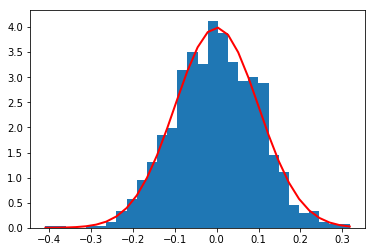

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 1000)
print(data.shape)

count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [3]:
from UQpy.Inference import Model
candidate_model = Model(model_type = 'pdf', model_name='normal')

In [4]:
from UQpy.Inference import MLEstimation
ml_estimator = MLEstimation(model_instance=candidate_model, data=data)
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f}'.format(ml_estimator.param[0], ml_estimator.param[1]))

Evaluating max likelihood estimate...
ML estimates of the mean=-0.002 and std. dev=0.101


## Regression model (model linear in the parameters)

In [5]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
from UQpy.RunModel import RunModel
z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')

data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[  1.04396395  -0.81651673  -0.4265468    3.37525295   1.98059299
   3.7419594    5.03864039   4.78414733   6.98927279   5.99701934
   9.7288079   14.19091468  12.37505701  17.08463029  21.02188361
  20.88650886  26.35586284  28.65113282  29.7909952   33.32913735
  37.86183935  41.21809591  44.42322118  48.73553632  51.59892795
  57.05177509  62.10447571  65.01600243  71.79766393  77.11835691
  83.528109    85.75466779  91.55996175  97.19442998 102.96390603
 109.78801082 114.30498033 121.06386872 128.05314126 133.86019069
 139.0134198  148.77740295 156.78121417 162.08349931 170.51719228
 178.55751322 184.61810283 193.61282195 201.57610807 210.72000711]


In [6]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [7]:
ml_estimator = MLEstimation(model_instance=candidate_model, data=data)

Evaluating max likelihood estimate...
(1, 2)
Optimization terminated successfully.
         Current function value: 75.000000
         Iterations: 43
         Function evaluations: 101


In [8]:
print(ml_estimator.param)

[1.0302345  1.99362138]
